In [1]:
include("../src/ha-one-asset-environment.jl") # loads functions which can be used to find an equillibrium
include("../src/ha-solution.jl") # loads functions which can be used to find an equillibrium
include("../src/ha-helper-functions.jl") # loads functions which can be used to find an equillibrium
include("../src/armington-trade-solution.jl") 
include("../src/armington-trade-environment.jl") 
include("../src/ha-trade-solution.jl") 


using Plots
using MINPACK
gr(fmt=:png); # setting for easier display in jupyter notebooks

  0.105172 seconds (3.52 k allocations: 110.297 MiB, 32.15% gc time)


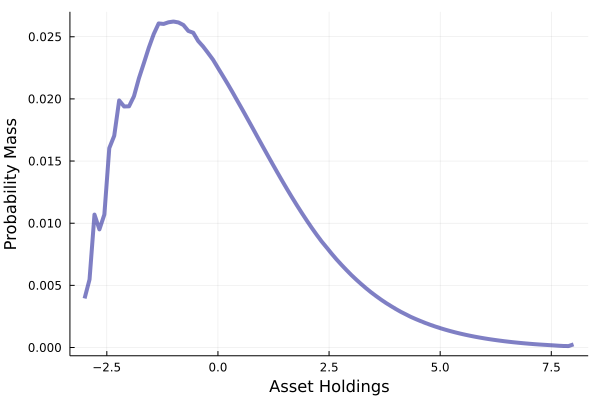

In [3]:
params = model_params(ρ = 0.20, σ = 0.3919, Nshocks = 10, Na = 100, ϕ = 3.0, amax = 8, σa = 0.005, γ = 3.0)
# parameter set to compare to previous notebooks

Pces = 1.0
W = 1.0
τ_rev = 0.0
R = 1.029

@time hh, dist = compute_eq(Pces, W, τ_rev, R, params);

adist = get_distribution(dist.state_index, dist.L);

plot(params.agrid, adist, alpha = 0.5, lw = 4,
    color = "dark blue", ylabel = "Probability Mass", xlabel = "Asset Holdings", label = false)

In [4]:
@btime hh, dist = compute_eq(Pces, W, τ_rev, R, params);

  54.438 ms (3508 allocations: 110.30 MiB)


### Financial Autarky Case

In [6]:
W = [1.0 , 1.0]

τ_revenue = [0.0,  0.0]

R = [1.029, 1.029]


@time ha_trade_equilibrium(W, τ_revenue, R, params, trade_params())

  0.156556 seconds (17.25 k allocations: 229.396 MiB, 15.79% gc time)


6-element Vector{Float64}:
 0.09814031799169931
 0.09814031799169931
 0.0
 0.0
 0.02591563551428492
 0.02591563551428492

In [7]:
haparams = model_params(ρ = 0.20, σ = 0.3919, Nshocks = 10, Na = 100, ϕ = 3.0, amax = 8, σa = 0.005, γ = 3.0)
trdparams = trade_params(d = [1.0 1.5; 1.75 1.0] )

Ncntry = trdparams.Ncntry

function f!(fvec, x)
    
    w_f = x[1:Ncntry] # this is the wage
    
    τ_f = x[Ncntry+1 : 2*Ncntry] # this is the tariff revenue...
    
    R_f = x[2*Ncntry + 1 : end] # this is each countries real rate

    fvec .= ha_trade_equilibrium(w_f, τ_f, R_f, haparams , trdparams )

end

f! (generic function with 1 method)

In [9]:
initial_x = [W; τ_revenue; R]

n = length(initial_x)
diag_adjust = n - 1

sol = fsolve(f!, initial_x, show_trace = true, method = :hybr;
      ml=diag_adjust, mu=diag_adjust,
      diag=ones(n),
      mode= 1,
      tol=1e-5,
       )

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     1.756087e-01     0.000000e+00         0.151000
     2     5.485157e-03     2.672928e-02         0.808000
     3     3.618777e-04     4.883550e-06         0.095000
     4     1.666996e-05     2.111758e-08         0.097000
     5     2.433985e-06     1.386436e-11         0.104000


Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [1.0, 1.0, 0.0, 0.0, 1.029, 1.029]
 * Zero: [1.0756627666349068, 1.1466610117622489, 3.1270778753193224e-21, 3.132453402225468e-21, 1.0275234495415468, 1.0276138343729255]
 * Inf-norm of residuals: 0.000002
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at most tol
 * Total time: 1.255000 seconds
 * Function Calls: 5
 * Jacobian Calls (df/dx): 1

### Financial Integration Case

using multiple dispatch here to seamlessly compute this case. Here is a first look...if you pass a scalar R to the function it returns 2* Ncntry + 1 conditions (demand, tariff revenue, and world bond market clearing). But if you look above -> 3*2*Ncountry conditions (demand, tariff, and each countries bond market). 

In [25]:
W = [1.0 , 1.0]

τ_revenue = [0.0,  0.0]

R = 1.029


@time ha_trade_equilibrium(W, τ_revenue, R, params, trade_params())

  0.141181 seconds (17.25 k allocations: 229.396 MiB, 9.93% gc time)


5-element Vector{Float64}:
 0.09814031799169931
 0.09814031799169931
 0.0
 0.0
 0.05183127102856984

In [23]:
haparams = model_params(ρ = 0.20, σ = 0.3919, Nshocks = 10, Na = 100, ϕ = 3.0, amax = 8, σa = 0.005, γ = 3.0)
trdparams = trade_params(d = [1.0 1.25; 1.25 1.0] )

Ncntry = trdparams.Ncntry

function f!(fvec, x)
    
    w_f = x[1:Ncntry] 
    
    τ_f = x[Ncntry+1 : 2*Ncntry] 
    
    R_f = x[2*Ncntry + 1] 
    # note now this is being grabed 
    # so when it's passed through...the type is recognized as scalar

    fvec .= ha_trade_equilibrium(w_f, τ_f, R_f, haparams , trdparams )

end

f! (generic function with 1 method)

In [24]:
initial_x = [W; τ_revenue; 1.029]

n = length(initial_x)
diag_adjust = n - 1

sol = fsolve(f!, initial_x, show_trace = true, method = :hybr;
      ml=diag_adjust, mu=diag_adjust,
      diag=ones(n),
      mode= 1,
      tol=1e-5,
       )

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     1.604894e-01     0.000000e+00         0.139000
     2     1.411357e-02     4.367283e-02         0.653000
     3     2.800213e-03     2.432005e-09         0.096000
     4     6.074848e-06     1.489915e-10         0.101000
     5     4.152064e-08     7.042467e-16         0.084000


Results of Nonlinear Solver Algorithm
 * Algorithm: Modified Powell
 * Starting Point: [1.0, 1.0, 0.0, 0.0, 1.029]
 * Zero: [1.1477587096621877, 1.1477587096636008, 1.0687098267819079e-22, 5.516965326675689e-24, 1.0263121504758157]
 * Inf-norm of residuals: 0.000000
 * Convergence: true
 * Message: algorithm estimates that the relative error between x and the solution is at most tol
 * Total time: 1.074000 seconds
 * Function Calls: 5
 * Jacobian Calls (df/dx): 1